In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import math
import pytz

from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## RNN:
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout # Careful
from keras.layers import BatchNormalization

In [ ]:
data_main = pd.read_csv('EV0_325_Final.csv')

In [ ]:
data_main

,Timestamp,EV_Final,Year,Month,Day,Hour
0,12/4/2019 1:00,0.000,2019,12,4,1
1,12/4/2019 2:00,248.251,2019,12,4,2
2,12/4/2019 3:00,219.049,2019,12,4,3
3,12/4/2019 4:00,249.788,2019,12,4,4
4,12/4/2019 5:00,235.955,2019,12,4,5
...,...,...,...,...,...,...
8034,11/2/2020 19:00,0.000,2020,11,2,19
8035,11/2/2020 20:00,0.000,2020,11,2,20
8036,11/2/2020 21:00,113.408,2020,11,2,21
8037,11/2/2020 22:00,0.000,2020,11,2,22


In [ ]:
# Change in the data 
data_main['Timestamp'] = pd.to_datetime(data_main["Year"].apply(str)+ "-" + data_main["Month"].apply(str) + "-" + data_main["Day"].apply(str) + " " + data_main["Hour"].apply(str) + ":00:00" , format='%Y-%m-%d %H:%M:%S')

In [ ]:
data_main

,Timestamp,EV_Final,Year,Month,Day,Hour
0,2019-12-04 01:00:00,0.000,2019,12,4,1
1,2019-12-04 02:00:00,248.251,2019,12,4,2
2,2019-12-04 03:00:00,219.049,2019,12,4,3
3,2019-12-04 04:00:00,249.788,2019,12,4,4
4,2019-12-04 05:00:00,235.955,2019,12,4,5
...,...,...,...,...,...,...
8034,2020-11-02 19:00:00,0.000,2020,11,2,19
8035,2020-11-02 20:00:00,0.000,2020,11,2,20
8036,2020-11-02 21:00:00,113.408,2020,11,2,21
8037,2020-11-02 22:00:00,0.000,2020,11,2,22


In [ ]:
df=data_main

In [ ]:
#Setting Timestamp as Index
df.set_index("Timestamp", inplace=True)

In [ ]:
df1=df.filter(['EV_Final'], axis=1)

In [ ]:
df1

,EV_Final
Timestamp,
2019-12-04 01:00:00,0.000
2019-12-04 02:00:00,248.251
2019-12-04 03:00:00,219.049
2019-12-04 04:00:00,249.788
2019-12-04 05:00:00,235.955
...,...
2020-11-02 19:00:00,0.000
2020-11-02 20:00:00,0.000
2020-11-02 21:00:00,113.408


In [ ]:
df2=df1.resample('240min').agg({"EV_Final":"sum"})

In [ ]:
df2

,EV_Final
Timestamp,
2019-12-04 00:00:00,467.300
2019-12-04 04:00:00,926.915
2019-12-04 08:00:00,934.598
2019-12-04 12:00:00,1474.866
2019-12-04 16:00:00,945.358
...,...
2020-11-02 04:00:00,1129.705
2020-11-02 08:00:00,1104.993
2020-11-02 12:00:00,0.000


In [ ]:
df2["EV_lag_1"] = df2["EV_Final"].shift(-1)
df2["EV_lag_2"] = df2["EV_Final"].shift(-2)
df2["EV_lag_3"] = df2["EV_Final"].shift(-3)
df2["EV_lag_4"] = df2["EV_Final"].shift(-4)
df2["EV_lag_5"] = df2["EV_Final"].shift(-5)
df2["EV_lag_6"] = df2["EV_Final"].shift(-6)

In [ ]:
df2=df2.reset_index()

In [ ]:
# We have every 4hours of data ready now
df3=df2.filter(['EV_Final','EV_lag_1','EV_lag_2','EV_lag_3','EV_lag_4','EV_lag_5','EV_lag_6'], axis=1)
df3

,EV_Final,EV_lag_1,EV_lag_2,EV_lag_3,EV_lag_4,EV_lag_5,EV_lag_6
0,467.300,926.915,934.598,1474.866,945.358,4659.243,1165.945
1,926.915,934.598,1474.866,945.358,4659.243,1165.945,911.545
2,934.598,1474.866,945.358,4659.243,1165.945,911.545,1170.556
3,1474.866,945.358,4659.243,1165.945,911.545,1170.556,1150.575
4,945.358,4659.243,1165.945,911.545,1170.556,1150.575,911.547
...,...,...,...,...,...,...,...
2005,1129.705,1104.993,0.000,1129.706,113.408,NaN,NaN
2006,1104.993,0.000,1129.706,113.408,NaN,NaN,NaN
2007,0.000,1129.706,113.408,NaN,NaN,NaN,NaN
2008,1129.706,113.408,NaN,NaN,NaN,NaN,NaN


In [ ]:
df3.drop(df3.tail(6).index,inplace = True)

In [ ]:
#df3 is our final dataset we need to use to predict the next days first 4 hours of charging
df3


,EV_Final,EV_lag_1,EV_lag_2,EV_lag_3,EV_lag_4,EV_lag_5,EV_lag_6
0,467.300,926.915,934.598,1474.866,945.358,4659.243,1165.945
1,926.915,934.598,1474.866,945.358,4659.243,1165.945,911.545
2,934.598,1474.866,945.358,4659.243,1165.945,911.545,1170.556
3,1474.866,945.358,4659.243,1165.945,911.545,1170.556,1150.575
4,945.358,4659.243,1165.945,911.545,1170.556,1150.575,911.547
...,...,...,...,...,...,...,...
1999,1152.874,0.000,1206.933,1313.506,1108.082,0.000,1129.705
2000,0.000,1206.933,1313.506,1108.082,0.000,1129.705,1104.993
2001,1206.933,1313.506,1108.082,0.000,1129.705,1104.993,0.000
2002,1313.506,1108.082,0.000,1129.705,1104.993,0.000,1129.706


In [ ]:
train=df3[0:1900]
test=df3[1900:2004]

In [ ]:
train_X=train[['EV_Final','EV_lag_1','EV_lag_2','EV_lag_3','EV_lag_4','EV_lag_5']]

In [ ]:
train_X=train[['EV_Final','EV_lag_1','EV_lag_2','EV_lag_3','EV_lag_4','EV_lag_5']]
train_y=train[['EV_lag_6']]
test_X=test[['EV_Final','EV_lag_1','EV_lag_2','EV_lag_3','EV_lag_4','EV_lag_5']]
test_y=test[['EV_lag_6']]

In [ ]:
#Scaling has to be done for LSTM
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc2= StandardScaler()
train_X_sc=sc.fit_transform(train_X)
train_y_sc=sc2.fit_transform(train_y)
test_X_sc=sc.transform(test_X)
test_y_sc=X_test = sc2.transform(test_y)

In [ ]:
train_X_sc = pd.DataFrame(train_X_sc)
train_y_sc = pd.DataFrame(train_y_sc)
test_X_sc = pd.DataFrame(test_X_sc)
test_y_sc = pd.DataFrame(test_y_sc)



In [ ]:
# create and fit the LSTM network 1
model = Sequential()
model.add(LSTM(6, input_shape=(6,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X_sc, train_y_sc, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1900/1900 - 5s - loss: 0.9783 - 5s/epoch - 3ms/step
Epoch 2/100
1900/1900 - 4s - loss: 0.9302 - 4s/epoch - 2ms/step
Epoch 3/100
1900/1900 - 4s - loss: 0.9267 - 4s/epoch - 2ms/step
Epoch 4/100
1900/1900 - 4s - loss: 0.9253 - 4s/epoch - 2ms/step
Epoch 5/100
1900/1900 - 4s - loss: 0.9230 - 4s/epoch - 2ms/step
Epoch 6/100
1900/1900 - 4s - loss: 0.9217 - 4s/epoch - 2ms/step
Epoch 7/100
1900/1900 - 4s - loss: 0.9181 - 4s/epoch - 2ms/step
Epoch 8/100
1900/1900 - 4s - loss: 0.9190 - 4s/epoch - 2ms/step
Epoch 9/100
1900/1900 - 4s - loss: 0.9174 - 4s/epoch - 2ms/step
Epoch 10/100
1900/1900 - 4s - loss: 0.9161 - 4s/epoch - 2ms/step
Epoch 11/100
1900/1900 - 4s - loss: 0.9153 - 4s/epoch - 2ms/step
Epoch 12/100
1900/1900 - 4s - loss: 0.9139 - 4s/epoch - 2ms/step
Epoch 13/100
1900/1900 - 4s - loss: 0.9129 - 4s/epoch - 2ms/step
Epoch 14/100
1900/1900 - 4s - loss: 0.9129 - 4s/epoch - 2ms/step
Epoch 15/100
1900/1900 - 4s - loss: 0.9102 - 4s/epoch - 2ms/step
Epoch 16/100
1900/1900 - 4s - loss

In [ ]:
# make predictions
trainPredict = pd.DataFrame(model.predict(train_X_sc))
testPredict = pd.DataFrame(model.predict(test_X_sc))

In [ ]:
# invert predictions
trainPredict = sc2.inverse_transform(trainPredict)
testPredict = sc2.inverse_transform(testPredict)

In [ ]:
trainPredict = pd.DataFrame(trainPredict)
testPredict = pd.DataFrame(testPredict)

In [ ]:
#invert train y and test y
train_y_plot = pd.DataFrame(sc2.inverse_transform(train_y_sc))
test_y_plot = pd.DataFrame(sc2.inverse_transform(test_y_sc))

In [ ]:
trainScore = math.sqrt(mean_squared_error(train_y_plot, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y_plot, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1412.13 RMSE
Test Score: 5336.44 RMSE


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
r2_score(train_y_plot, trainPredict)

0.15357254759607686

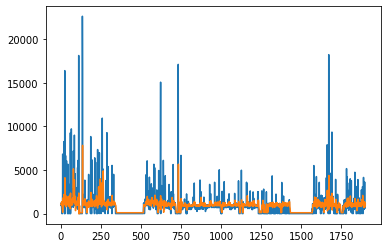

In [ ]:
# plot baseline and predictions
plt.plot(train_y_plot)
plt.plot(trainPredict)
plt.show()

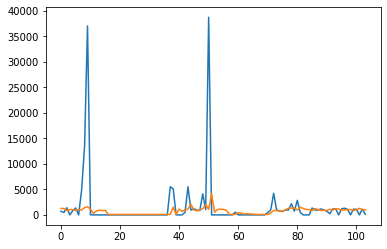

In [ ]:
plt.plot(test_y_plot)
plt.plot(testPredict)
plt.show()

In [ ]:
from numpy import savetxt
# save to csv file
savetxt('features.csv', trainPredict, delimiter=',')
savetxt('features2.csv', train_y_plot, delimiter=',')

In [ ]:
# MAPE function
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def median_ape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.median(np.abs((actual - pred) / actual)) * 100

In [ ]:
# Calculate MAPE
mape_train = mape(train_y_plot+0.01, trainPredict)
mape_test = mape(test_y_plot+0.01, testPredict)
print("MAPE of training set:",np.round(mape_train,2), "MAPE of testing set:", np.round(mape_test,2))



MAPE of training set: 1170978.01 MAPE of testing set: 2666855.81


In [ ]:
# create and fit the LSTM network 2
model = Sequential()
model.add(LSTM(6, return_sequences=True, input_shape=(6,1)))
model.add(LSTM(6))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = Adam(clipvalue=1.0)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.fit(train_X_sc, train_y_sc, epochs=100, batch_size=24, verbose=2)

Epoch 1/100
80/80 - 5s - loss: 0.9671 - 5s/epoch - 58ms/step
Epoch 2/100
80/80 - 1s - loss: 0.9530 - 574ms/epoch - 7ms/step
Epoch 3/100
80/80 - 1s - loss: 0.9428 - 593ms/epoch - 7ms/step
Epoch 4/100
80/80 - 1s - loss: 0.9469 - 594ms/epoch - 7ms/step
Epoch 5/100
80/80 - 1s - loss: 0.9332 - 590ms/epoch - 7ms/step
Epoch 6/100
80/80 - 1s - loss: 0.9399 - 574ms/epoch - 7ms/step
Epoch 7/100
80/80 - 1s - loss: 0.9407 - 580ms/epoch - 7ms/step
Epoch 8/100
80/80 - 1s - loss: 0.9400 - 581ms/epoch - 7ms/step
Epoch 9/100
80/80 - 1s - loss: 0.9397 - 589ms/epoch - 7ms/step
Epoch 10/100
80/80 - 1s - loss: 0.9397 - 575ms/epoch - 7ms/step
Epoch 11/100
80/80 - 1s - loss: 0.9364 - 579ms/epoch - 7ms/step
Epoch 12/100
80/80 - 1s - loss: 0.9266 - 569ms/epoch - 7ms/step
Epoch 13/100
80/80 - 1s - loss: 0.9362 - 578ms/epoch - 7ms/step
Epoch 14/100
80/80 - 1s - loss: 0.9377 - 567ms/epoch - 7ms/step
Epoch 15/100
80/80 - 1s - loss: 0.9229 - 579ms/epoch - 7ms/step
Epoch 16/100
80/80 - 1s - loss: 0.9210 - 575ms/epoc

In [ ]:
trainScore = math.sqrt(mean_squared_error(train_y_plot, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y_plot, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1454.86 RMSE
Test Score: 5348.94 RMSE


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
r2_score(train_y_plot, trainPredict)

0.10156996303494115

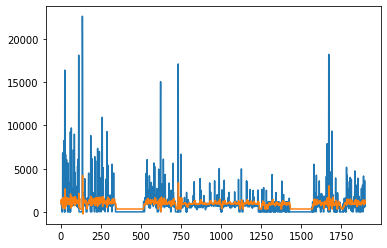

In [ ]:
# plot baseline and predictions
plt.plot(train_y_plot)
plt.plot(trainPredict)
plt.show()

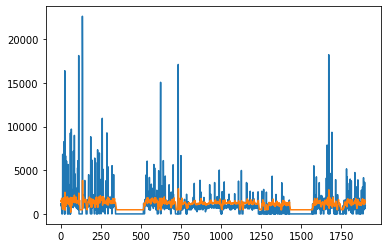

In [ ]:
# plot baseline and predictions
plt.plot(train_y_plot)
plt.plot(trainPredict)
plt.show()

In [ ]:
# Calculate MAPE
mape_train = mape(train_y_plot+0.01, trainPredict)
mape_test = mape(test_y_plot+0.01, testPredict)
print("MAPE of training set:",np.round(mape_train,2), "MAPE of testing set:", np.round(mape_test,2))



MAPE of training set: 1636168.59 MAPE of testing set: 3389315.72
